In [1]:
import numpy as np
import pandas as pd

df_train = pd.read_csv('./titanic/train.csv')
len(df_train)

891

In [2]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
df_train = df_train.drop(['Name', 'Ticket', 'PassengerId', 'Cabin'], axis=1)
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [4]:
df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df_train.isnull().any()

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
Embarked     True
dtype: bool

In [6]:
train_age_mean = float(round(df_train['Age'].mean()))
train_embarked_mean = 'S'
train_fare_mean = df_train['Fare'].mean()

In [7]:
df_train['Age'].fillna(train_age_mean, inplace=True)
df_train['Embarked'].fillna(train_embarked_mean, inplace=True) # as most frequent 'Embarked' 

In [8]:
df_train = pd.get_dummies(df_train, columns=['Sex', 'Embarked'])

In [9]:
features2standartization = ['Age', 'Fare']

tmp = df_train[features2standartization]
tmp_training_mean = tmp.mean()
tmp_training_std = tmp.std()

In [10]:
df_train[features2standartization] = (df_train[features2standartization] - tmp_training_mean) / tmp_training_std
df_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,-0.596720,1,0,-0.502163,0,1,0,0,1
1,1,1,0.633806,1,0,0.786404,1,0,1,0,0
2,1,3,-0.289088,0,0,-0.488580,1,0,0,0,1
3,1,1,0.403083,1,0,0.420494,1,0,0,0,1
4,0,3,0.403083,0,0,-0.486064,0,1,0,0,1


In [11]:
df_target = df_train['Survived']
df_features = df_train.drop('Survived', axis=1)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(df_features, df_target, test_size=0.2)
len(X_train), len(X_val)

(712, 179)

In [13]:
import torch

def get_acc(pred, gt):
    
    if isinstance(pred, torch.Tensor) or isinstance(gt, torch.Tensor):
        pred = pred.detach().numpy()
        gt = gt.detach().numpy()
    
    pred_class = (pred > 0.5).astype(int)   

    correct = (gt == pred_class).sum().item()
    return correct / len(gt)

In [14]:
from catboost import CatBoostRegressor

catboost = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    subsample=0.8,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

catboost.fit(X_train, Y_train)

Y_prediction = catboost.predict(X_val)
get_acc(Y_prediction, Y_val)

0:	learn: 0.4791916	total: 165ms	remaining: 2m 44s
100:	learn: 0.3407141	total: 244ms	remaining: 2.18s
200:	learn: 0.3220679	total: 330ms	remaining: 1.31s
300:	learn: 0.3085355	total: 414ms	remaining: 960ms
400:	learn: 0.2962379	total: 496ms	remaining: 741ms
500:	learn: 0.2811074	total: 580ms	remaining: 578ms
600:	learn: 0.2694696	total: 666ms	remaining: 442ms
700:	learn: 0.2589183	total: 752ms	remaining: 321ms
800:	learn: 0.2499099	total: 837ms	remaining: 208ms
900:	learn: 0.2416684	total: 923ms	remaining: 101ms
999:	learn: 0.2348613	total: 1.01s	remaining: 0us


0.8659217877094972

In [15]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_val)
get_acc(Y_prediction, Y_val)

0.8156424581005587

### MLP

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

X_tr_tensor = torch.Tensor(X_train.values)
Y_tr_tensor = torch.Tensor(Y_train.values)

X_vl_tensor = torch.Tensor(X_val.values)
Y_vl_tensor = torch.Tensor(Y_val.values)

X_tr_tensor.shape, Y_tr_tensor.shape, X_vl_tensor.shape, Y_vl_tensor.shape

(torch.Size([712, 10]),
 torch.Size([712]),
 torch.Size([179, 10]),
 torch.Size([179]))

In [17]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_dataset = TensorDataset(X_tr_tensor, Y_tr_tensor)
val_dataset = TensorDataset(X_vl_tensor, Y_vl_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [18]:
class BCModel(nn.Module):
    def __init__(self, input_dim):
        super(BCModel, self).__init__()
        
        mid_shape = 32
        self.fc1 = nn.Linear(input_dim, mid_shape)
        self.fc2 = nn.Linear(mid_shape, 1)
        
    def forward(self, x):
        out = self.fc1(x)
        out = torch.tanh(out)
        out = self.fc2(out).squeeze(1)
        return out
    
model = BCModel(10)
model

BCModel(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [19]:
sum([p.nelement() for p in model.parameters()])

385

In [20]:
import torch.optim as optim

_lr = 3e-2

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(params=model.parameters(), lr=_lr)

In [21]:
test_x = X_tr_tensor[:batch_size]
test_y = Y_tr_tensor[:batch_size]

out = model(test_x)

print(f'Input shape: {test_x.shape}; label shape: {test_y.shape}; out shape: {out.shape} \n')

loss = criterion(out, test_y)
acc = get_acc(out, test_y)

print(f'Loss: {loss.item():.4f}, acc: {acc:.4f}')

Input shape: torch.Size([32, 10]); label shape: torch.Size([32]); out shape: torch.Size([32]) 

Loss: 0.6502, acc: 0.7188


In [22]:
current_eph = 0
t_loss_eph = []
t_acc_eph = []

v_loss_eph = []
v_acc_eph = []

In [23]:
for eph in range(current_eph, current_eph + 30):
    print(f" {'-' * 5} Epoch: {eph} {'-' * 5}")
    current_eph += 1
    t_losses = []
    t_acc = []

    for batch, label in train_dataloader:
        out = model(batch)
        prob = torch.sigmoid(out)
        
        loss = criterion(out, label)
        t_losses.append(loss.item())
        t_acc.append(get_acc(prob, label))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_eph = sum(t_losses) / len(t_losses)
    acc_eph = sum(t_acc) / len(t_acc)
    
    t_loss_eph.append(loss_eph)
    t_acc_eph.append(acc_eph)
    
    print(f'Train loss: {loss_eph:.4f}; acc: {acc_eph:.4f}')
    
    v_losses = []
    v_acc = []
    for batch, label in val_dataloader:
        out = model(batch)
        prob = torch.sigmoid(out)
        
        loss = criterion(out, label)
        v_losses.append(loss.item())
        v_acc.append(get_acc(prob, label))
        
    loss_eph = sum(v_losses) / len(v_losses)
    acc_eph = sum(v_acc) / len(v_acc)
    
    v_loss_eph.append(loss_eph)
    v_acc_eph.append(acc_eph)    
    
    print(f'Val loss: {loss_eph:.4f}; acc: {acc_eph:.4f}')

 ----- Epoch: 0 -----
Train loss: 0.6436; acc: 0.6386
Val loss: 0.6448; acc: 0.5806
 ----- Epoch: 1 -----
Train loss: 0.6101; acc: 0.6522
Val loss: 0.6229; acc: 0.5962
 ----- Epoch: 2 -----
Train loss: 0.5898; acc: 0.6780
Val loss: 0.6016; acc: 0.6467
 ----- Epoch: 3 -----
Train loss: 0.5722; acc: 0.6943
Val loss: 0.5815; acc: 0.6571
 ----- Epoch: 4 -----
Train loss: 0.5563; acc: 0.7106
Val loss: 0.5630; acc: 0.6850
 ----- Epoch: 5 -----
Train loss: 0.5419; acc: 0.7215
Val loss: 0.5464; acc: 0.6902
 ----- Epoch: 6 -----
Train loss: 0.5290; acc: 0.7283
Val loss: 0.5317; acc: 0.7338
 ----- Epoch: 7 -----
Train loss: 0.5176; acc: 0.7541
Val loss: 0.5189; acc: 0.7634
 ----- Epoch: 8 -----
Train loss: 0.5077; acc: 0.7772
Val loss: 0.5080; acc: 0.7791
 ----- Epoch: 9 -----
Train loss: 0.4992; acc: 0.7758
Val loss: 0.4987; acc: 0.7791
 ----- Epoch: 10 -----
Train loss: 0.4920; acc: 0.7840
Val loss: 0.4909; acc: 0.7895
 ----- Epoch: 11 -----
Train loss: 0.4858; acc: 0.7853
Val loss: 0.4845; ac

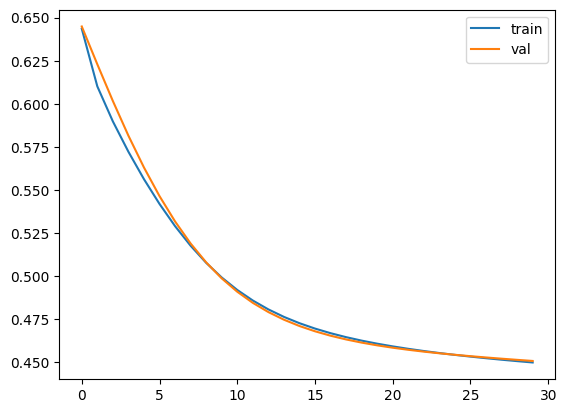

In [24]:
import matplotlib.pyplot as plt

plt.plot(t_loss_eph, label='train')
plt.plot(v_loss_eph, label='val')
plt.legend()
plt.show()

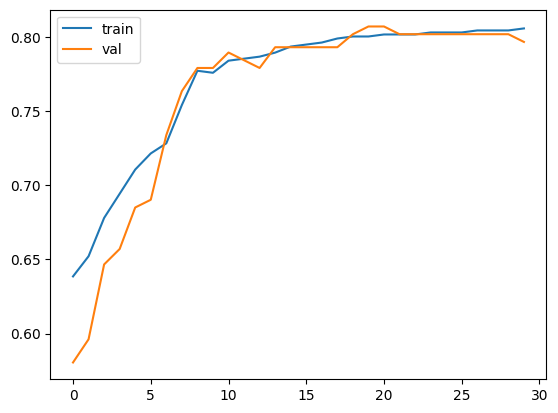

In [25]:
plt.plot(t_acc_eph, label='train')
plt.plot(v_acc_eph, label='val')
plt.legend()
plt.show()

### MLP from scratch

In [32]:
input_dim = X_train.shape[1]
mid_dim = 32

# W1 = np.random.uniform(0, 1, (input_dim, mid_dim)).astype(np.float32) * 0.01
# b1 = np.random.uniform(0, 1, (mid_dim)).astype(np.float32) 

# W2 = np.random.uniform(0, 1, (mid_dim, 1)).astype(np.float32) * 0.01
# b2 = np.random.uniform(0, 1, (1)).astype(np.float32)

# parameters = [W1, b1, W2, b2]
# sum([p.size for p in parameters])

# W1.shape, b1.shape, W2.shape, b2.shape

In [33]:
W1 = torch.rand((input_dim, mid_dim)) * 0.01
b1 = torch.rand((mid_dim)) 

W2 = torch.rand((mid_dim, 1)) * 0.01
b2 = torch.rand((1))

W1.shape, b1.shape, W2.shape, b2.shape

(torch.Size([10, 32]), torch.Size([32]), torch.Size([32, 1]), torch.Size([1]))

In [34]:
parameters = [W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

sum([p.nelement() for p in parameters])

385

In [35]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [36]:
_batch_size = 32
_lr = 5e-2

current_eph = 0
t_loss_eph = []
t_acc_eph = []

v_loss_eph = []
v_acc_eph = []

In [38]:
import math

for eph in range(current_eph, current_eph + 30):
    print(f" {'-' * 5} Epoch: {eph} {'-' * 5}")
    current_eph += 1
    t_losses = []
    t_acc = []

    for i in range(int(len(X_train) / _batch_size) + 1):
        batch_idx = np.arange(_batch_size * i, min(_batch_size * (i + 1), len(X_train)))
        
        X = X_tr_tensor[batch_idx]
        Y = Y_tr_tensor[batch_idx].unsqueeze(1)
        #Y = np.expand_dims(Y_train.values[batch_idx], 1) # convert shape (32) to (32, 1)
        
        Z1 = X @ W1 + b1
        A1 = (math.e**Z1 - math.e**(-Z1)) / (math.e**Z1 + math.e**(-Z1)) # tanh
        Z2 = A1 @ W2 + b2

        probs = 1 / (1 + math.e**(-Z2))
        
        loss = - (Y * probs.log() + (1 - Y) * (1 - probs).log()).sum() / len(Y)
        t_losses.append(loss)
        t_acc.append(get_acc(probs, Y))
        
        dZ2 = (probs - Y) / X.size(0)
        dW2 = A1.T @ dZ2
        db2 = dZ2.sum(axis=0)

        dA1 = dZ2 @ W2.T
        dZ1 = dA1 * (1 - A1**2)

        dW1 = X.T @ dZ1
        db1 = dZ1.sum(axis=0)
        
        grads = [dW1, db1, dW2, db2]

        # for p in parameters:
        #     p.grad = None
        # loss.backward()
        # cmp('w2', dW2, W2)
        # cmp('b2', db2, b2)
        # cmp('w1', dW1, W1)
        # cmp('b1', db1, b1)
        
        for param, grad in zip(parameters, grads):
            param.data += -_lr * grad

    loss_eph = sum(t_losses) / len(t_losses)
    acc_eph = sum(t_acc) / len(t_acc)
    
    t_loss_eph.append(loss_eph)
    t_acc_eph.append(acc_eph)
    
    print(f'Train loss: {loss_eph:.4f}; acc: {acc_eph:.4f}')
    
    v_losses = []
    v_acc = []
    for i in range(int(len(X_train) / _batch_size) + 1):
        batch_idx = np.arange(_batch_size * i, min(_batch_size * (i + 1), len(X_train)))
        
        X = X_tr_tensor[batch_idx]
        Y = Y_tr_tensor[batch_idx].unsqueeze(1)
        
        Z1 = X @ W1 + b1
        A1 = (math.e**Z1 - math.e**(-Z1)) / (math.e**Z1 + math.e**(-Z1)) # tanh
        Z2 = A1 @ W2 + b2

        probs = 1 / (1 + math.e**(-Z2))
        
        loss = - (Y * probs.log() + (1 - Y) * (1 - probs).log()).sum() / len(Y)
        
        v_losses.append(loss)
        v_acc.append(get_acc(probs, Y))
        
    loss_eph = sum(v_losses) / len(v_losses)
    acc_eph = sum(v_acc) / len(v_acc)
    
    v_loss_eph.append(loss_eph)
    v_acc_eph.append(acc_eph)    
    
    print(f'Val loss: {loss_eph:.4f}; acc: {acc_eph:.4f}')

 ----- Epoch: 1 -----
Train loss: 0.6904; acc: 0.5380
Val loss: 0.6552; acc: 0.6318
 ----- Epoch: 2 -----
Train loss: 0.6557; acc: 0.6318
Val loss: 0.6525; acc: 0.6318
 ----- Epoch: 3 -----
Train loss: 0.6529; acc: 0.6318
Val loss: 0.6496; acc: 0.6318
 ----- Epoch: 4 -----
Train loss: 0.6498; acc: 0.6318
Val loss: 0.6464; acc: 0.6318
 ----- Epoch: 5 -----
Train loss: 0.6465; acc: 0.6318
Val loss: 0.6429; acc: 0.6318
 ----- Epoch: 6 -----
Train loss: 0.6427; acc: 0.6318
Val loss: 0.6389; acc: 0.6318
 ----- Epoch: 7 -----
Train loss: 0.6384; acc: 0.6332
Val loss: 0.6342; acc: 0.6332
 ----- Epoch: 8 -----
Train loss: 0.6332; acc: 0.6332
Val loss: 0.6286; acc: 0.6345
 ----- Epoch: 9 -----
Train loss: 0.6271; acc: 0.6345
Val loss: 0.6219; acc: 0.6345
 ----- Epoch: 10 -----
Train loss: 0.6198; acc: 0.6386
Val loss: 0.6139; acc: 0.6413
 ----- Epoch: 11 -----
Train loss: 0.6111; acc: 0.6413
Val loss: 0.6045; acc: 0.6454
 ----- Epoch: 12 -----
Train loss: 0.6009; acc: 0.6481
Val loss: 0.5935; a

### Inference

In [39]:
df_test = pd.read_csv('./titanic/test_y.csv')
df_test = df_test.drop(['Name', 'Ticket', 'PassengerId', 'Cabin'], axis=1)
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,34.5,0,0,7.8292,Q,0
1,3,female,47.0,1,0,7.0000,S,1
2,2,male,62.0,0,0,9.6875,Q,0
3,3,male,27.0,0,0,8.6625,S,0
4,3,female,22.0,1,1,12.2875,S,1


In [40]:
df_test.isnull().any()

Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare         True
Embarked    False
Survived    False
dtype: bool

In [41]:
df_test['Age'].fillna(30, inplace=True)
df_test['Embarked'].fillna('S', inplace=True) # as most frequent 'Embarked' 
df_test['Fare'].fillna(train_fare_mean, inplace=True)

df_test[features2standartization] = (df_test[features2standartization] - tmp_training_mean) / tmp_training_std

In [42]:
df_test = pd.get_dummies(df_test, ['Sex', 'Embarked'])

In [43]:
df_test_y = df_test['Survived']
df_test_features = df_test.drop('Survived', axis=1)

In [44]:
df_features.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,-0.596720,1,0,-0.502163,0,1,0,0,1
1,1,0.633806,1,0,0.786404,1,0,1,0,0
2,3,-0.289088,0,0,-0.488580,1,0,0,0,1
3,1,0.403083,1,0,0.420494,1,0,0,0,1
4,3,0.403083,0,0,-0.486064,0,1,0,0,1


In [45]:
df_test_features.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,0.364629,0,0,-0.490508,0,1,0,1,0
1,3,1.325977,1,0,-0.507194,1,0,0,0,1
2,2,2.479595,0,0,-0.453112,0,1,0,1,0
3,3,-0.212180,0,0,-0.473739,0,1,0,0,1
4,3,-0.596720,1,1,-0.400792,1,0,0,0,1


In [46]:
df_features.describe() - df_test_features.describe()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
count,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000
mean,0.043092,-0.035194,0.075639,-0.010751,-0.068717,-0.011223,0.011223,-0.055467,-0.023628,0.079095
std,-0.005766,0.028268,0.205984,-0.175372,-0.123705,-0.003632,-0.003632,-0.038647,-0.032184,-0.032052
min,0.000000,0.019227,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,-0.076908,0.000000,0.000000,0.000294,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,-0.057681,0.000000,0.000000,-0.010062,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.000000,0.307631,0.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [47]:
X_test = df_test_features.values
Y_test = df_test_y.values

X_test.shape, Y_test.shape

((418, 10), (418,))

In [142]:
Y_pred = catboost.predict(df_test_features)
get_acc(Y_pred, df_test_y)

0.7751196172248804

In [140]:
Y_pred = random_forest.predict(df_test_features)
get_acc(Y_pred, df_test_y)

0.7464114832535885

In [50]:
X_test = torch.Tensor(df_test_features.values)
Y_test = torch.Tensor(df_test_y.values)

X_test.shape, Y_test.shape

(torch.Size([418, 10]), torch.Size([418]))

In [51]:
pred = model(X_test)
pred = torch.sigmoid(pred)
pred.shape

torch.Size([418])

In [52]:
get_acc(pred, Y_test)

0.7607655502392344

### ROC AUC analysis

In [215]:
thresholds = np.arange(0, 1.025, 0.025)
thresholds

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975, 1.   ])

In [216]:
def get_conf_matrix_el(pred, gt, th=0.5):

    TP = np.sum((pred > th) & (gt == 1))
    FP = np.sum((pred > th) & (gt == 0))

    TN = np.sum((pred <= th) * (gt == 0))
    FN = np.sum((pred <= th) * (gt == 1))

    return TP, FP, TN, FN

In [217]:
import sys

def get_roc_auc(pred, gt):
    tp_list, fn_list, tn_list, fn_list = [], [], [], []
    prec_list, rec_list, f1_list = [], [], []
    tpr_list, fpr_list = [], []

    for th in thresholds:
        tp, fp, tn, fn = get_conf_matrix_el(pred, gt, th)

        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        prec = tp / (tp + fp + sys.float_info.epsilon)
        rec = tp / (tp + fn + sys.float_info.epsilon)
        F1 = 2 * (prec * rec) / (prec + rec + sys.float_info.epsilon)
        
        prec_list.append(prec)
        rec_list.append(rec)
        f1_list.append(F1)

        tp_list.append(tp)
        fn_list.append(fn)
        tn_list.append(tn)
        fn_list.append(fn)

        tpr_list.append(tpr)
        fpr_list.append(fpr)
        
    return tpr_list, fpr_list, prec_list, rec_list, f1_list #, tp_list, fn_list, tn_list, fn_list

In [218]:
tpr_list, fpr_list, prec_list, rec_list, f1_list = get_roc_auc(pred.detach().numpy(), Y_test.detach().numpy())

In [219]:
rnd_tpr_list, rnd_fpr_list, rnd_prec_list, rnd_rec_list, rnd_f1_list = get_roc_auc(np.random.rand(len(pred)), Y_test.detach().numpy())

In [228]:
cb_tpr_list, cb_fpr_list, cb_prec_list, cb_rec_list, cb_f1_list = get_roc_auc(np.array(Y_pred), np.array(df_test_y))

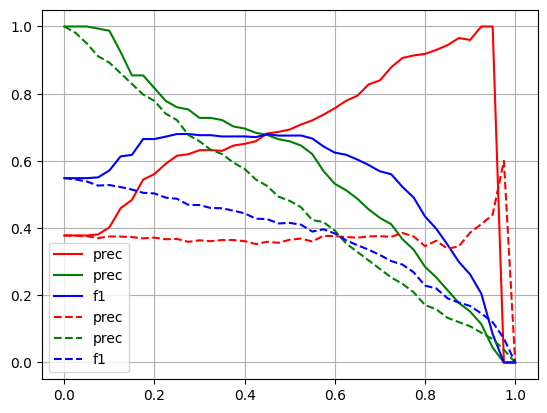

In [229]:
plt.plot(thresholds, prec_list, label='prec', color='r')
plt.plot(thresholds, rec_list, label='prec', color='g')
plt.plot(thresholds, f1_list, label='f1', color='b')

plt.plot(thresholds, rnd_prec_list, 'r--', label='prec')
plt.plot(thresholds, rnd_rec_list, 'g--', label='prec')
plt.plot(thresholds, rnd_f1_list, 'b--', label='f1')

plt.grid(True)
plt.legend()
plt.show()

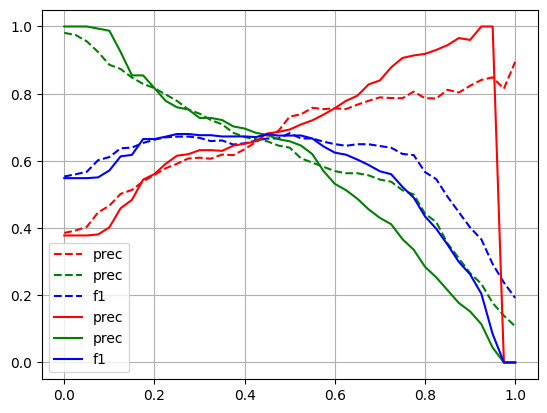

In [231]:
plt.plot(thresholds, cb_prec_list, 'r--', label='prec')
plt.plot(thresholds, cb_rec_list, 'g--', label='prec')
plt.plot(thresholds, cb_f1_list, 'b--', label='f1')

plt.plot(thresholds, prec_list, label='prec', color='r')
plt.plot(thresholds, rec_list, label='prec', color='g')
plt.plot(thresholds, f1_list, label='f1', color='b')

plt.grid(True)
plt.legend()
plt.show()

In [232]:
positive_rate = np.sum(Y_test.detach().numpy()) / len( Y_test.detach().numpy())
positive_rate

0.37799043062200954

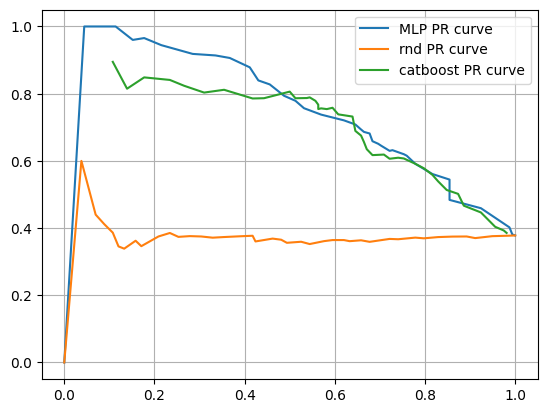

In [234]:
plt.plot(rec_list, prec_list, label='MLP PR curve')
plt.plot(rnd_rec_list, rnd_prec_list, label='rnd PR curve')
plt.plot(cb_rec_list, cb_prec_list, label='catboost PR curve')

plt.grid(True)
plt.legend()
plt.show()

In [238]:
from sklearn.metrics import auc

mlp_fpr_list, mlp_tpr_list = zip(*sorted(zip(fpr_list, tpr_list)))
rnd_fpr_list, rnd_tpr_list = zip(*sorted(zip(rnd_fpr_list, rnd_tpr_list)))
cb_fpr_list, cb_tpr_list = zip(*sorted(zip(cb_fpr_list, cb_tpr_list)))

mlp_auc = auc(mlp_fpr_list, mlp_tpr_list)
rnd_auc = auc(rnd_fpr_list, rnd_tpr_list)
cb_auc = auc(cb_fpr_list, cb_tpr_list)

mlp_auc, rnd_auc, cb_auc

(0.8078870496592016, 0.4814873417721519, 0.7429284323271665)

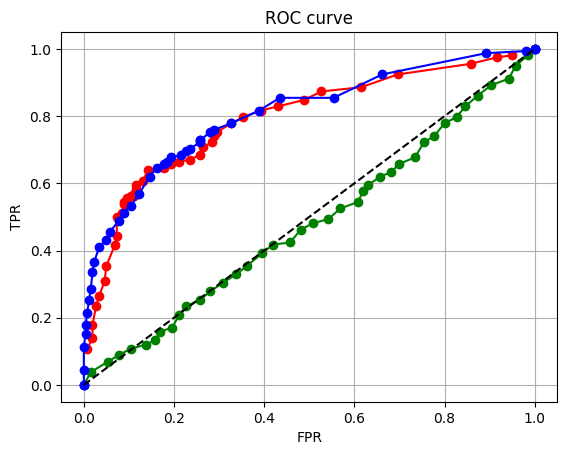

In [239]:
import matplotlib.pyplot as plt

plt.plot(cb_fpr_list, cb_tpr_list, marker='o', label='ROC curve', color='r')
plt.plot(rnd_fpr_list, rnd_tpr_list, marker='o', label='ROC curve', color='g')
plt.plot(mlp_fpr_list, mlp_tpr_list, marker='o', label='ROC curve', color='b')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.grid(True)
plt.show()